#TASK 1: Dataset preprocessing


Used SymPy to generate datasets of functions along with their Taylor expansions up to the fourth order.

In [18]:
import sympy as sp
import pandas as pd

In [19]:
x = sp.Symbol('x')

functions = [
    sp.sin(x), sp.cos(x), sp.exp(x), sp.log(x + 1), sp.sqrt(x),
    sp.tan(x), sp.sec(x), sp.csc(x), sp.cot(x),
    sp.atan(x), sp.asin(x), sp.acos(x),
    sp.sinh(x), sp.cosh(x), sp.tanh(x), sp.sech(x), sp.csch(x), sp.coth(x),
    x**2, x**3, x**4,
    x**5, sp.sin(x) * sp.exp(x), sp.log(x + 1) + sp.cos(x), sp.sqrt(x) * sp.log(x + 1),
    sp.tan(x) ** 2, (sp.sec(x) - 1) ** 2, sp.csc(x) + x, sp.cot(x) * x,
    sp.atan(x ** 2), sp.asin(x / 2), sp.acos(x / 3),
    sp.sinh(x) / x, sp.cosh(x) + x, sp.tanh(x) ** 2, sp.sech(x) ** 2, sp.csch(x) * x, sp.coth(x) / x,
    x**6, x**7, x**(1/2), x**(1/3), x**(-1), x**(-2),
    x**2 * sp.sin(x), x * sp.cosh(x),
    sp.asin(x**2), sp.atanh(sp.sqrt(x)),
    sp.log(x, 2) + 1, sp.exp(x**2 - 1),
    sp.Abs(x), sp.sign(x),
    sp.sqrt(x**2 + sp.sin(x)),
]

In [20]:
data = []
for func in functions:
    taylor_expansion = func.series(x, 0, 5).removeO()
    data.append({'Function': func, 'Taylor_Expansion': taylor_expansion})

df = pd.DataFrame(data)

df.to_csv('function_dataset.csv', index=False)

In [21]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenized the dataset


In [22]:
df = pd.read_csv('function_dataset.csv')

df['Function_Tokens'] = df['Function'].apply(lambda func: word_tokenize(str(func)))
df['Taylor_Expansion_Tokens'] = df['Taylor_Expansion'].apply(lambda taylor_exp: word_tokenize(str(taylor_exp)))

df.to_csv('tokenized_function_dataset.csv', index=False)

#TASK 2: Use LSTM model


In [23]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [37]:
df = pd.read_csv('tokenized_function_dataset.csv')

vocab = set()
for tokens in df['Function_Tokens']:
    vocab.update(tokens)
for tokens in df['Taylor_Expansion_Tokens']:
    vocab.update(tokens)

word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

In [38]:
X = [[word2idx[word] for word in tokens] for tokens in df['Function_Tokens']]
y = [[word2idx[word] for word in tokens] for tokens in df['Taylor_Expansion_Tokens']]

max_len = max(max(len(seq) for seq in X), max(len(seq) for seq in y))
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')


In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
embedding_dim = 50
vocab_size = len(word2idx) + 1

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(units=128, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=110, batch_size=64)

Epoch 1/110
1/1 [==============================] - 5s 5s/step - loss: 3.6814 - val_loss: 3.6487
Epoch 2/110
1/1 [==============================] - 0s 130ms/step - loss: 3.6487 - val_loss: 3.6135
Epoch 3/110
1/1 [==============================] - 0s 116ms/step - loss: 3.6135 - val_loss: 3.5718
Epoch 4/110
1/1 [==============================] - 0s 99ms/step - loss: 3.5718 - val_loss: 3.5177
Epoch 5/110
1/1 [==============================] - 0s 66ms/step - loss: 3.5177 - val_loss: 3.4400
Epoch 6/110
1/1 [==============================] - 0s 100ms/step - loss: 3.4400 - val_loss: 3.3139
Epoch 7/110
1/1 [==============================] - 0s 108ms/step - loss: 3.3140 - val_loss: 3.0709
Epoch 8/110
1/1 [==============================] - 0s 110ms/step - loss: 3.0707 - val_loss: 2.5131
Epoch 9/110
1/1 [==============================] - 0s 111ms/step - loss: 2.5116 - val_loss: 1.8013
Epoch 10/110
1/1 [==============================] - 0s 117ms/step - loss: 1.7928 - val_loss: 1.4038
Epoch 11/110
1

In [45]:
from nltk.metrics import edit_distance

y_pred = model.predict(X_val)

y_pred_tokens = [[idx2word[token] for token in sequence if token != 0] for sequence in np.argmax(y_pred, axis=-1)]
y_val_tokens = [[idx2word[token] for token in sequence if token != 0] for sequence in y_val]

def token_level_accuracy(y_true, y_pred):
    correct = 0
    total_tokens = 0
    for true_seq, pred_seq in zip(y_true, y_pred):
        total_tokens += len(true_seq)
        for true_token, pred_token in zip(true_seq, pred_seq):
            if true_token == pred_token:
                correct += 1
    return correct / total_tokens

1/1 [==============================] - 1s 763ms/step


#TASK 3: Use Transformer model

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [46]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, d_model, num_heads, dropout, name="encoder_layer"):
        super(EncoderLayer, self).__init__(name=name)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



In [47]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, d_model, num_heads, dropout, name="decoder_layer"):
        super(DecoderLayer, self).__init__(name=name)
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(units, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.dropout3 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, enc_output, training=False):
        attn1 = self.mha1(inputs, inputs)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(inputs + attn1)
        attn2 = self.mha2(out1, enc_output)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)

In [48]:
def transformer_model(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = Input(shape=(None,), name="inputs")
    dec_inputs = Input(shape=(None,), name="dec_inputs")

    enc_embedding = Embedding(input_dim=vocab_size, output_dim=d_model)(inputs)
    dec_embedding = Embedding(input_dim=vocab_size, output_dim=d_model)(dec_inputs)

    enc_output = enc_embedding
    for i in range(num_layers):
        enc_output = EncoderLayer(units, d_model, num_heads, dropout, name="encoder_layer_{}".format(i))(enc_output)

    dec_output = dec_embedding
    for i in range(num_layers):
        dec_output = DecoderLayer(units, d_model, num_heads, dropout, name="decoder_layer_{}".format(i))(dec_output, enc_output)

    outputs = Dense(vocab_size, activation='softmax', name="outputs")(dec_output)

    return Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

vocab_size = len(word2idx) + 1
num_layers = 4
units = 512
d_model = 256
num_heads = 8
dropout = 0.1

model = transformer_model(vocab_size, num_layers, units, d_model, num_heads, dropout)
model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy())
model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], validation_data=([X_val, y_val[:, :-1]], y_val[:, 1:]), epochs=160, batch_size=64)

Epoch 1/160
1/1 [==============================] - 70s 70s/step - loss: 4.3581 - val_loss: 2.6388
Epoch 2/160
1/1 [==============================] - 1s 1s/step - loss: 2.4948 - val_loss: 8.0117
Epoch 3/160
1/1 [==============================] - 1s 1s/step - loss: 7.7043 - val_loss: 1.4832
Epoch 4/160
1/1 [==============================] - 1s 1s/step - loss: 1.4014 - val_loss: 1.3112
Epoch 5/160
1/1 [==============================] - 1s 1s/step - loss: 1.2511 - val_loss: 1.1609
Epoch 6/160
1/1 [==============================] - 1s 1s/step - loss: 1.1475 - val_loss: 1.1894
Epoch 7/160
1/1 [==============================] - 1s 1s/step - loss: 1.1857 - val_loss: 1.0867
Epoch 8/160
1/1 [==============================] - 1s 1s/step - loss: 1.0616 - val_loss: 1.1401
Epoch 9/160
1/1 [==============================] - 1s 1s/step - loss: 1.0998 - val_loss: 1.1940
Epoch 10/160
1/1 [==============================] - 1s 1s/step - loss: 1.1461 - val_loss: 1.1775
Epoch 11/160
1/1 [===================

In [49]:
import matplotlib.pyplot as plt

def generate_data(x):
    return np.sin(x)

x = np.linspace(-2*np.pi, 2*np.pi, 400)
y = generate_data(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train, x_test = x_train.reshape(-1, 1), x_test.reshape(-1, 1)

model = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)


3/3 [==============================] - 0s 4ms/step


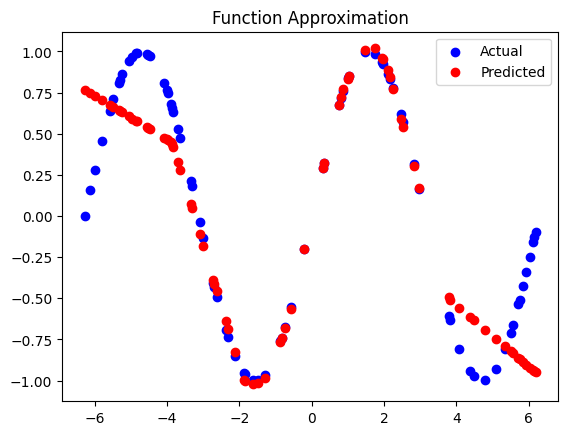

In [51]:
predictions = model.predict(x_test)

plt.scatter(x_test, y_test, color='blue', label='Actual')
plt.scatter(x_test, predictions, color='red', label='Predicted')
plt.title('Function Approximation')
plt.legend()
plt.show()

In [35]:
functions = [
    np.sin,
    np.cos,
    lambda x: x**2,
    np.tanh,
]

x_range = np.linspace(-2*np.pi, 2*np.pi, 400)

for func in functions:
    y = func(x_range)
    x_train, x_test, y_train, y_test = train_test_split(x_range, y, test_size=0.2, random_state=42)

    x_train, x_test = x_train.reshape(-1, 1), x_test.reshape(-1, 1)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(1,)),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

3/3 [==============================] - 0s 4ms/step


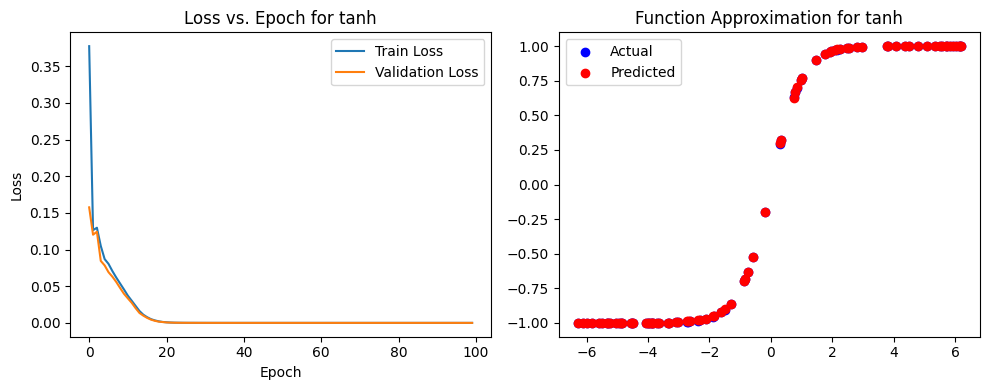

In [36]:

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epoch for {}'.format(func.__name__))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    predictions = model.predict(x_test)

    plt.subplot(1, 2, 2)
    plt.scatter(x_test, y_test, color='blue', label='Actual')
    plt.scatter(x_test, predictions, color='red', label='Predicted')
    plt.title('Function Approximation for {}'.format(func.__name__))
    plt.legend()
    plt.tight_layout()
    plt.show()
